In [10]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
data = pd.read_csv('ELC.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume'])
data = data.reset_index(drop=True)
data.head()

,close
0,4409.937988
1,4347.826172
2,4347.826172
3,4347.826172
4,4335.403809


In [11]:
price = data['close'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test
train_size = int(len(price_scaled) * 0.7)
test_size = len(price_scaled) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [4]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.1)

Epoch 1/100
13/13 [==============================] - 2s 54ms/step - loss: 0.0682 - val_loss: 0.0622
Epoch 2/100
13/13 [==============================] - 0s 38ms/step - loss: 0.0682 - val_loss: 0.0622
Epoch 3/100
13/13 [==============================] - 0s 36ms/step - loss: 0.0682 - val_loss: 0.0622
Epoch 4/100
13/13 [==============================] - 0s 33ms/step - loss: 0.0682 - val_loss: 0.0622
Epoch 5/100
13/13 [==============================] - 0s 36ms/step - loss: 0.0682 - val_loss: 0.0622
Epoch 6/100
13/13 [==============================] - 0s 33ms/step - loss: 0.0682 - val_loss: 0.0622
Epoch 7/100
13/13 [==============================] - 0s 37ms/step - loss: 0.0682 - val_loss: 0.0622
Epoch 8/100
13/13 [==============================] - 0s 34ms/step - loss: 0.0682 - val_loss: 0.0622
Epoch 9/100
13/13 [==============================] - 0s 37ms/step - loss: 0.0682 - val_loss: 0.0622
Epoch 10/100
13/13 [==============================] - 0s 33ms/step - loss: 0.0682 - val_loss: 0.0622

In [5]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


12/12 [==============================] - 0s 7ms/step


In [6]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-30:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 [==============================] - 0s 20ms/step
[[2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]
 [2583.8508]]


In [7]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MLSE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_msle = mean_squared_log_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 14470.325484353656
MAPE trên tập test là: 80.50257433804848 %
MSLE trên tập test là: 3.128736329391426


In [8]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index

next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(data), len(data)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = data[:train_size][['close']]
test_data_df = data[train_size:][['close']]

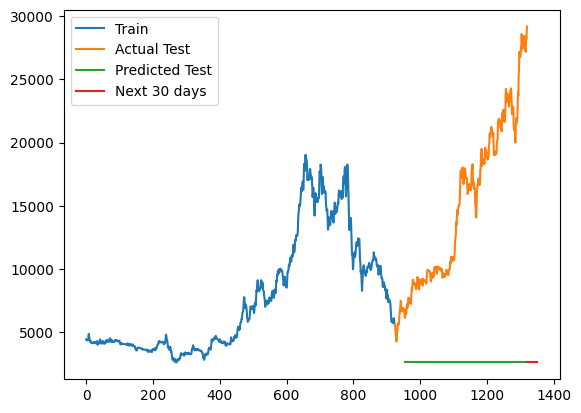

In [9]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()

# (Split 8/2)

In [13]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
data = pd.read_csv('ELC.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume'])
data = data.reset_index(drop=True)
data.head()

,close
0,4409.937988
1,4347.826172
2,4347.826172
3,4347.826172
4,4335.403809


In [14]:
price = data['close'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test
train_size = int(len(price_scaled) * 0.8)
test_size = len(price_scaled) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [15]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.1)

Epoch 1/100
15/15 [==============================] - 4s 108ms/step - loss: 0.0285 - val_loss: 7.6385e-04
Epoch 2/100
15/15 [==============================] - 1s 46ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 3/100
15/15 [==============================] - 1s 35ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 4/100
15/15 [==============================] - 1s 37ms/step - loss: 0.0023 - val_loss: 8.0382e-04
Epoch 5/100
15/15 [==============================] - 1s 45ms/step - loss: 0.0020 - val_loss: 3.8806e-04
Epoch 6/100
15/15 [==============================] - 1s 37ms/step - loss: 0.0021 - val_loss: 5.2002e-04
Epoch 7/100
15/15 [==============================] - 1s 49ms/step - loss: 0.0019 - val_loss: 3.0822e-04
Epoch 8/100
15/15 [==============================] - 1s 77ms/step - loss: 0.0020 - val_loss: 5.4452e-04
Epoch 9/100
15/15 [==============================] - 1s 80ms/step - loss: 0.0019 - val_loss: 3.0244e-04
Epoch 10/100
15/15 [==============================] - 2s 122ms/step - l

In [16]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

8/8 [==============================] - 0s 6ms/step


In [17]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-30:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 [==============================] - 0s 26ms/step
[[22799.13 ]
 [22877.572]
 [22062.1  ]
 [21085.088]
 [19956.03 ]
 [19112.422]
 [18753.98 ]
 [18515.791]
 [18269.986]
 [18036.492]
 [17833.113]
 [17585.072]
 [17212.592]
 [16768.727]
 [16382.616]
 [16116.995]
 [15896.938]
 [15550.814]
 [14974.419]
 [14211.147]
 [13339.399]
 [12770.646]
 [12921.473]
 [13077.395]
 [13429.521]
 [13729.246]
 [13850.933]
 [14040.119]
 [14224.046]
 [14263.629]]


In [18]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MLSE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_msle = mean_squared_log_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 2375.7854516987177
MAPE trên tập test là: 8.276530019704168 %
MSLE trên tập test là: 0.011841737054037097


In [19]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index

next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(data), len(data)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = data[:train_size][['close']]
test_data_df = data[train_size:][['close']]

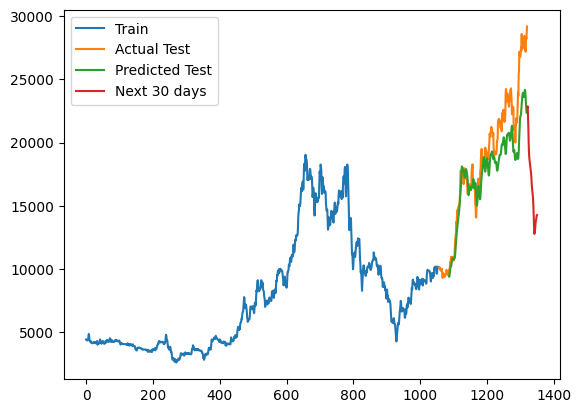

In [20]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()

# (Split 9/1)

In [21]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
data = pd.read_csv('ELC.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume'])
data = data.reset_index(drop=True)
data.head()

,close
0,4409.937988
1,4347.826172
2,4347.826172
3,4347.826172
4,4335.403809


In [22]:
price = data['close'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test
train_size = int(len(price_scaled) * 0.9)
test_size = len(price_scaled) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [23]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.1)

Epoch 1/100
17/17 [==============================] - 2s 46ms/step - loss: 0.0085 - val_loss: 0.0040
Epoch 2/100
17/17 [==============================] - 1s 35ms/step - loss: 0.0022 - val_loss: 0.0053
Epoch 3/100
17/17 [==============================] - 1s 34ms/step - loss: 0.0019 - val_loss: 0.0094
Epoch 4/100
17/17 [==============================] - 1s 35ms/step - loss: 0.0019 - val_loss: 0.0052
Epoch 5/100
17/17 [==============================] - 1s 47ms/step - loss: 0.0017 - val_loss: 0.0047
Epoch 6/100
17/17 [==============================] - 1s 61ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 7/100
17/17 [==============================] - 1s 59ms/step - loss: 0.0017 - val_loss: 0.0053
Epoch 8/100
17/17 [==============================] - 1s 58ms/step - loss: 0.0020 - val_loss: 0.0037
Epoch 9/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0017 - val_loss: 0.0084
Epoch 10/100
17/17 [==============================] - 1s 35ms/step - loss: 0.0019 - val_loss: 0.0036

In [24]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

4/4 [==============================] - 0s 7ms/step


In [25]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-30:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 [==============================] - 0s 21ms/step
[[24998.738]
 [25217.379]
 [24725.777]
 [23825.352]
 [22910.48 ]
 [22262.494]
 [21931.219]
 [21678.479]
 [21470.885]
 [21292.783]
 [21102.7  ]
 [20868.096]
 [20510.336]
 [20111.42 ]
 [19791.168]
 [19583.87 ]
 [19422.818]
 [19128.078]
 [18599.236]
 [17916.33 ]
 [17122.576]
 [16565.736]
 [16557.014]
 [16806.82 ]
 [17099.133]
 [17307.771]
 [17521.87 ]
 [17780.85 ]
 [17954.748]
 [17988.773]]


In [26]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MLSE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_msle = mean_squared_log_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 2156.190819595403
MAPE trên tập test là: 7.275426741724066 %
MSLE trên tập test là: 0.00826190260025505


In [27]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index

next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(data), len(data)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = data[:train_size][['close']]
test_data_df = data[train_size:][['close']]

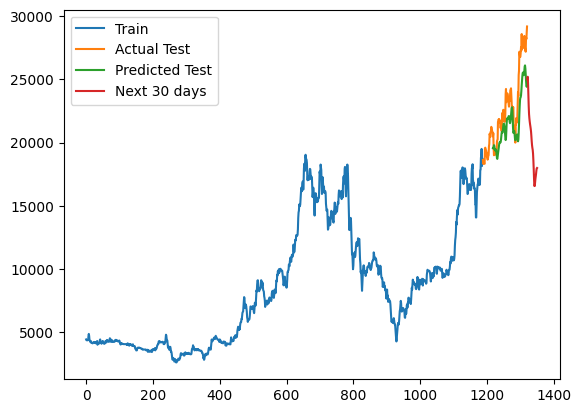

In [28]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()